# TMD A12B for specific eta

In [40]:
pip install -U pysr

Note: you may need to restart the kernel to use updated packages.


Julia and Julia dependencies are installed at first import:

In [42]:
import pysr

Now, let's import everything else as well as the PySRRegressor:


In [44]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
import h5py

# PySR for A12B eta = 8:


In [57]:

file_path = "/Users/hariprashadravikumar/sivers_TMD_PhD_project/save_h5_A12B_A2B/eta_Pb_bsquare_Amp_err_withb0.h5"
#with h5py.File(file_path, "r") as h5_file:
#    # Specify the dataset to extract
#    dataset_name = "Pl-2/eta_8_Pb_bsq_A12B_err"
#    data = np.array(h5_file[dataset_name])

P1 = 1
data_list = []
with h5py.File(file_path, "r") as h5_file:
    dataset_name = f"Pl-{P1}/eta_8_Pb_bsq_A12B_err"
    dataPl = np.array(h5_file[dataset_name])    
    data_list.append(dataPl)

data = np.vstack(data_list)
# Extract bLbT and A12B
Pbbsq = data[:, 1:3]  
A12B = data[:, 3]   
A12Berr = data[:, 4]
A12Bweight = [1/sigma**2 for sigma in A12Berr]


#print("bLbT =", bLbT)
#print("A12B =", A12B)
#print("A12Berr =", A12Berr)

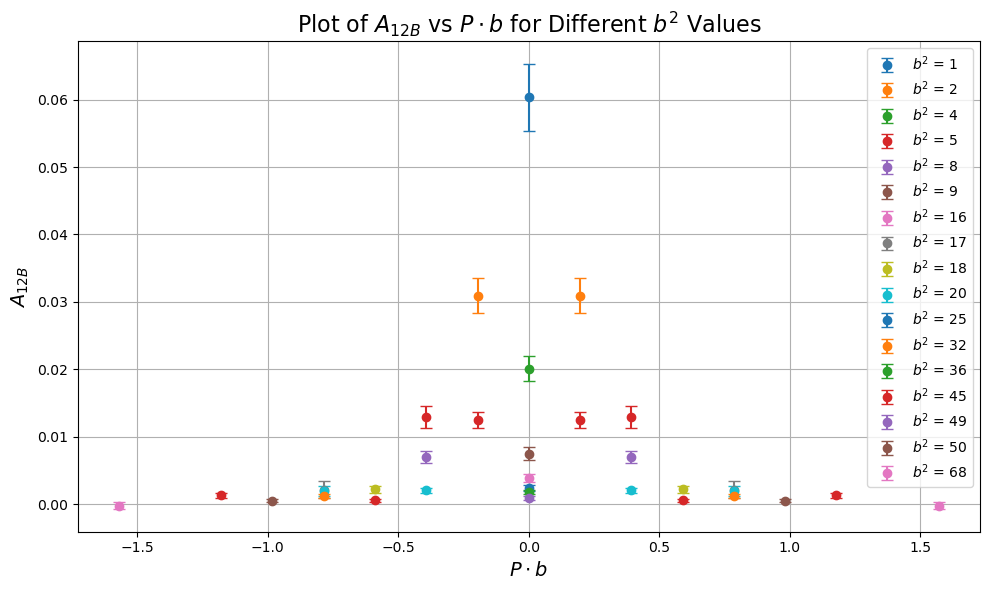

In [59]:

# Extract unique bT values
unique_bsq = np.unique(Pbbsq[:, 1])

# Create the plot
plt.figure(figsize=(10, 6))

for i, bsq in enumerate(unique_bsq):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = Pbbsq[:, 1] == bsq
    Pb_values = Pbbsq[mask, 0]
    A12B_values = A12B[mask]
    A12B_errors = A12Berr[mask]

    # Plot with error bars
    plt.errorbar(
        Pb_values,
        A12B_values,
        yerr=A12B_errors,
        fmt='o',
        label=f"$b^2$ = {int(bsq)}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("$P\cdot b$", fontsize=14)
plt.ylabel("$A_{12B}$", fontsize=14)
plt.title("Plot of $A_{12B}$ vs $P\cdot b$ for Different $b^2$ Values", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


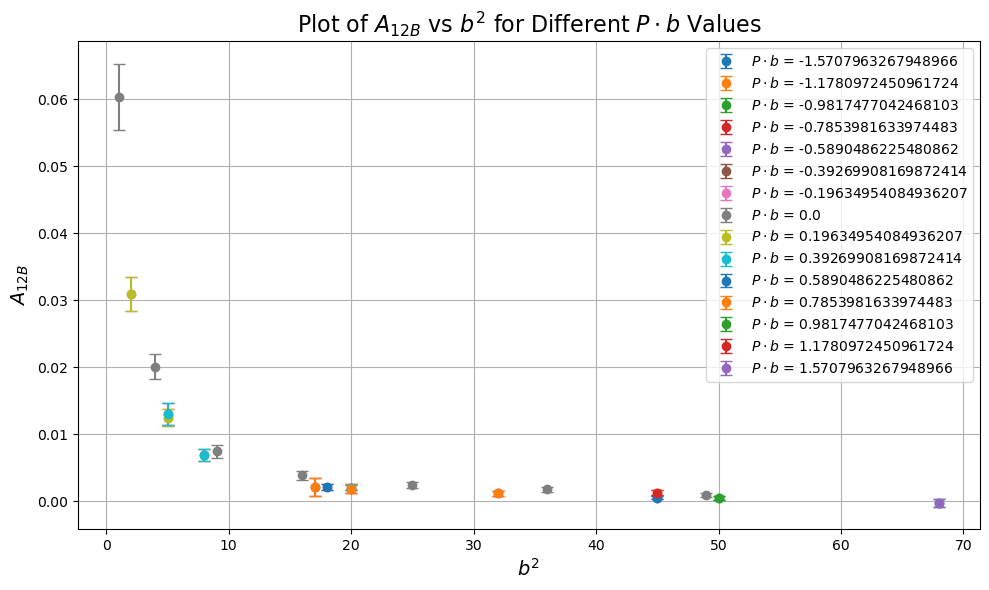

In [61]:
# Extract unique bT values
unique_Pb = np.unique(Pbbsq[:, 0])

# Create the plot
plt.figure(figsize=(10, 6))

for i, Pb in enumerate(unique_Pb):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = Pbbsq[:, 0] == Pb
    Psq_values = Pbbsq[mask, 1]
    A12B_values = A12B[mask]
    A12B_errors = A12Berr[mask]

    # Plot with error bars
    plt.errorbar(
        Psq_values,
        A12B_values,
        yerr=A12B_errors,
        fmt='o',
        label=f"$P\cdot b$ = {Pb}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("$b^2$", fontsize=14)
plt.ylabel("$A_{12B}$", fontsize=14)
plt.title("Plot of $A_{12B}$ vs $b^2$ for Different $P\cdot b$ Values", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


By default, we will set up 30 populations of expressions (which evolve independently except for migrations), use 4 threads, and use `"best"` for our model selection strategy:

In [63]:
default_pysr_params = dict(
    populations=100,
    model_selection="best",
)

In [65]:
from sympy import exp, sech, symbols, Function

custom_loss_function = """
using Symbolics

function eval_loss(tree, dataset::Dataset{T,L}, options)::L where {T,L}
    prediction, flag = eval_tree_array(tree, dataset.X, options)
    if !flag
        return L(Inf)
    end
    
    wmse = sum(dataset.weights .* (prediction .- dataset.y) .^ 2) / (dataset.n * sum(dataset.weights))
    return wmse
end
"""

extra_sympy_mappings = {
    "Lorentzian": lambda x, y: 1 / (y + x**2),
    "gaussian": lambda x: exp(-x**2),
    "decay": lambda x: exp(-x),
    "sech": lambda x: sech(x)
}

modelold = PySRRegressor(
    niterations=50,
    unary_operators=["gaussian(x) = exp(-x^2)",  "sech", "decay(x) = exp(-x)"],
    binary_operators=["*"],
    extra_sympy_mappings=extra_sympy_mappings,  # Include the custom mappings
    loss_function=custom_loss_function,  # Use the custom loss function
    nested_constraints = { "gaussian": {"gaussian": 0, "sech": 0, "decay": 0},"sech": {"sech": 0, "gaussian": 0, "decay": 0},  "decay": {"sech": 0, "gaussian": 0, "decay": 0}},
    constraints={'gaussian': (-1, 1), 'sech': (-1, 1), 'decay': (-1, 1)}

)

model = PySRRegressor(
    niterations=100,
    unary_operators=["gaussian(x) = exp(-x^2)", "sech"],
    binary_operators=["*", "Lorentzian(x, y) = 1/(y + x^2)"],
    extra_sympy_mappings=extra_sympy_mappings,  # Include the custom mappings
    loss_function=custom_loss_function,  # Use the custom loss function
    nested_constraints = { "gaussian": {"gaussian": 0, "sech": 0, "Lorentzian": 0},"sech": {"sech": 0, "gaussian": 0, "Lorentzian": 0},  "Lorentzian": {"sech": 0, "gaussian": 0, "Lorentzian": 0}},
    constraints={'gaussian': (-1, 1), 'sech': (-1, 1), 'Lorentzian': (-1, 1)}

)


model.fit(Pbbsq, A12B, weights=A12Bweight, variable_names=['Pb', 'bsq'])



/opt/homebrew/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 1.310e+05
Progress: 846 / 3100 total iterations (27.290%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.687e-07  1.594e+01  y = 0.0013934
3           2.358e-08  9.839e-01  y = Lorentzian(bsq, 38.545)
5           1.461e-08  2.395e-01  y = Lorentzian(Pb, bsq) * 0.054877
7           5.461e-09  4.918e-01  y = Lorentzian(bsq * -0.15011, bsq) * 0.067475
9           5.331e-09  1.204e-02  y = Lorentzian(bsq * (Pb * 0.24268), bsq) * 0.062508
10          4.577e-09  1.525e-01  y = sech(Pb) * (0.067819 * Lorentzian(bsq * -0.12116, bsq)...
                                      )
16          4.406e-09  6.374e-03  y = bsq * (Lorentzian(-0.19235, bsq) * ((0.068732 * Lorent...
                                      zian(bsq * -0.1215, bsq)) * sech(Pb)))
17     

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                       0.0013934076   
	1         0.983942                         Lorentzian(bsq, 38.657757)   
	2         0.239463                  Lorentzian(Pb, bsq) * 0.054876667   
	3   >>>>  0.491903    Lorentzian(bsq * -0.15107948, bsq) * 0.06768502   
	4         0.012215  Lorentzian((Pb * -0.24517037) * bsq, bsq) * 0....   
	5         0.155102  (Lorentzian(bsq * -0.1163581, bsq) * sech(Pb))...   
	6         0.032192  (Lorentzian(bsq * 0.10602401, bsq) * Lorentzia...   
	7         0.000092  (Lorentzian(Pb * -0.94525343, 1.0260916) * Lor...   
	8         0.027572  ((sech(Pb) * (Lorentzian(-0.50289804, bsq) * 0...   
	9         0.054751  ((Lorentzian(bsq * -0.1224141, bsq) * Lorentzi...   
	10        0.000271  ((bsq * ((Lorentzian(Pb, 1.1678987) * (Lorentz...   
	
	            loss  complexity  
	0   1.687147e-07           1  
	1   2.357827e-08           3  
	2   1.460552e-08           5  
	3   5.460795e-09           7  
	4   5.329000e-09           9  
	5   4.563369e-09          10  
	6   4.418804e-09          11  
	7   4.417993e-09          13  
	8   4.067257e-09          16  
	9   3.850558e-09          17  
	10  3.842223e-09          25  
]

  - outputs/20250316_134615_biJMxn/hall_of_fame.csv


In [74]:
model.sympy(5)

0.06726731*sech(Pb)/(0.01353920743561*bsq**2 + bsq)

In [ ]:
model.latex(7)

We can also view the SymPy of any other expression in the list, using the index of it in `model.equations_`.

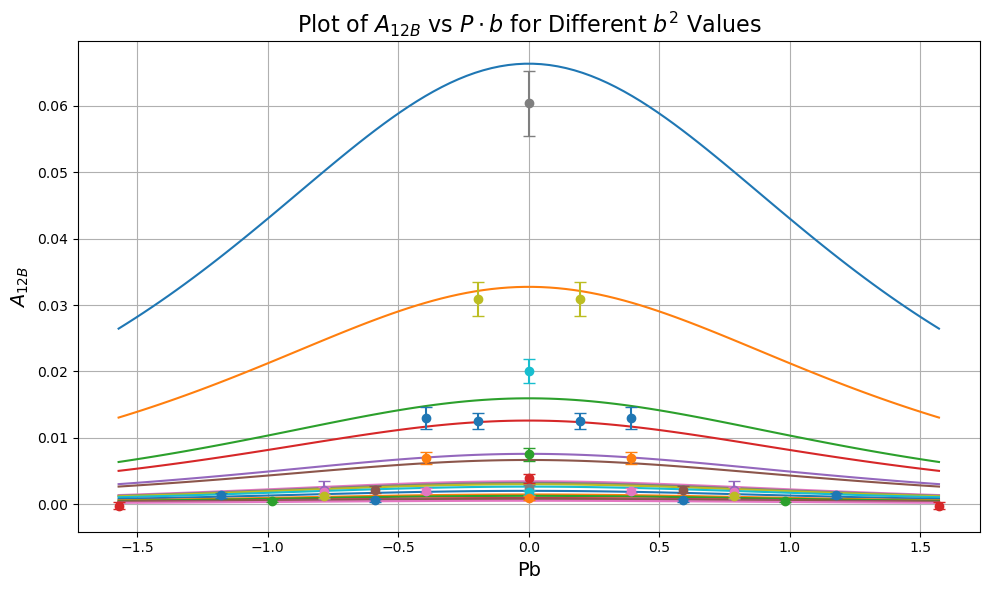

0.06726731*sech(Pb)/(0.01353920743561*bsq**2 + bsq)

In [76]:
pick = 5


Pb_plot = np.linspace(-max(unique_Pb),max(unique_Pb), 100)
plt.figure(figsize=(10, 6))

for bsq in unique_bsq:
    Pbbsq_plot = np.array([[Pb, bsq] for Pb in Pb_plot])
    predictions = model.predict(Pbbsq_plot, pick)
    plt.plot(Pb_plot, predictions)
for i, bsq in enumerate(unique_bsq):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = Pbbsq[:, 1] == bsq
    Pb_values = Pbbsq[mask, 0]
    A12B_values = A12B[mask]
    A12B_errors = A12Berr[mask]

    # Plot with error bars
    plt.errorbar(
        Pb_values,
        A12B_values,
        yerr=A12B_errors,
        fmt='o',
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("Pb", fontsize=14)
plt.ylabel("$A_{12B}$", fontsize=14)
plt.title("Plot of $A_{12B}$ vs $P\cdot b$ for Different $b^2$ Values", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()



model.sympy(pick)

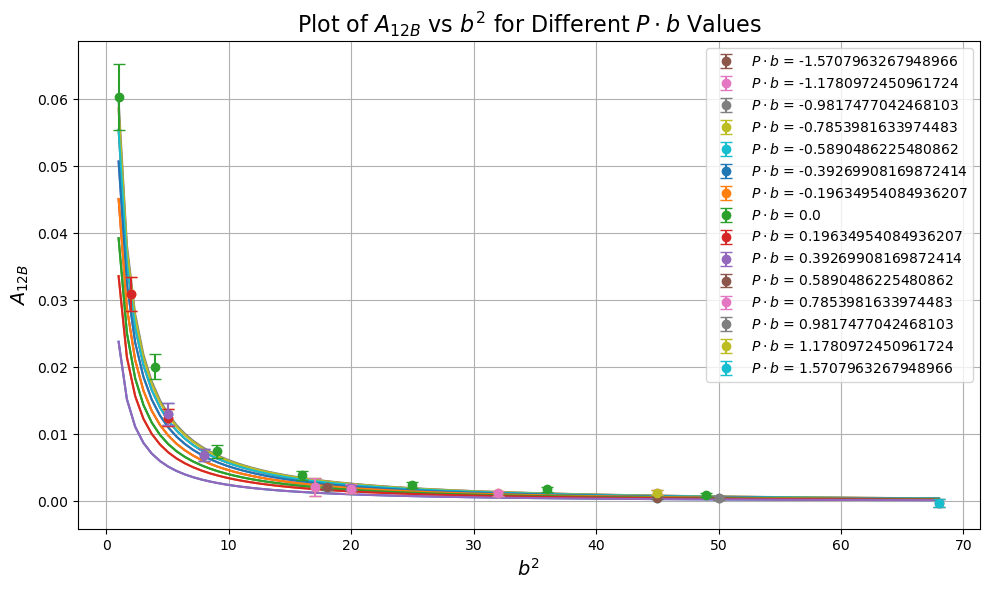

0.07648652*bsq*sech(Pb)/((bsq + 0.252906438635842)*(0.0212842743335161*bsq**2 + bsq))

In [72]:

b2_plot = np.linspace(1,max(unique_bsq), 100)
plt.figure(figsize=(10, 6))

for Pb in unique_Pb:
    Pbbsq_plott = np.array([[Pb, bsq] for bsq in b2_plot])
    predictions = model.predict(Pbbsq_plott, pick)
    plt.plot(b2_plot, predictions)

for i, Pb in enumerate(unique_Pb):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = Pbbsq[:, 0] == Pb
    Psq_values = Pbbsq[mask, 1]
    A12B_values = A12B[mask]
    A12B_errors = A12Berr[mask]

    # Plot with error bars
    plt.errorbar(
        Psq_values,
        A12B_values,
        yerr=A12B_errors,
        fmt='o',
        label=f"$P\cdot b$ = {Pb}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("$b^2$", fontsize=14)
plt.ylabel("$A_{12B}$", fontsize=14)
plt.title("Plot of $A_{12B}$ vs $b^2$ for Different $P\cdot b$ Values", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

model.sympy(pick)


In [ ]:
model.equations_[["complexity", "loss", "equation"]]